In [243]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold

COLOR_FONT = 'dimgray'
COLOR_PLOT = 'tan'

plt.rcParams.update(
    {
        'figure.figsize': [5, 3],
        'text.color': COLOR_FONT,
        'axes.edgecolor': COLOR_FONT,
        'axes.labelcolor': COLOR_FONT,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.titlecolor': COLOR_FONT,
        'axes.titlesize': 18,
        'xaxis.labellocation': 'left',
        'yaxis.labellocation': 'top',
        'xtick.color': COLOR_FONT,
        'ytick.color': COLOR_FONT,
        'xtick.bottom': False,
        'ytick.left': False,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
    }
)

In [244]:
data = pd.read_csv('../data/real_estate_clean.csv')
data.sample(3)

,id,price,address,coordinates,region,subway,floor,features,residential,neighborhood,description,detail,attributes,num_rooms,full_area,living_area,kitchen_area,num_storeys
3752,11399927,18000,"Ахматової Анни вул., 22","30.62496376,50.40853119","Київ,Дарницький р-н",Позняки,15,"['Бетонно монолітний', 'Роздільне', 'Євроремонт']","ЖК на вул. Ахматової, 22",NaN,Актуально! Можливі перегляди!\n\nПропонуємо в ...,"Будинок - Бетонно монолітний, в квартирі 1 кім...","['Лічильники', 'Кондиціонер', 'Пральна машина'...",1,56.0,20.0,15.0,25
1401,11293734,29800,"Берестейський пров. (Брест-Литовський), 5В","30.48665428,50.4465332","Київ,Шевченківський р-н",Вокзальна,22,"['Українська цегла', 'Роздільне', 'Чудовий стан']",ЖК Victory V,"['Міністерство освіти і науки', 'Універмаг Укр...","1к. просп. Берестейський (Перемоги) 5-В. ЖК "" ...","Будинок - Українська цегла, в квартирі 1 кімна...",NaN,1,46.0,19.5,15.0,33
8380,11350020,40500,"Глибочицька вул., 73","30.50396919,50.46321487","Київ,Шевченківський р-н",Контрактова площа,16,"['Бетонно монолітний', 'Роздільне', 'Дизайнерс...",NaN,"['Радіовежа', 'Щекавиця', 'Поділ', 'Юрковиця']","Запрошуємо на перегляд, квартири з неймовірним...","Будинок - Бетонно монолітний, в квартирі 2 кім...","['Посудомийна машина', 'Кондиціонер', 'Мікрохв...",2,75.0,32.0,16.0,25


In [245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10800 non-null  int64  
 1   price         10800 non-null  int64  
 2   address       10800 non-null  object 
 3   coordinates   10694 non-null  object 
 4   region        10800 non-null  object 
 5   subway        8747 non-null   object 
 6   floor         10800 non-null  int64  
 7   features      10800 non-null  object 
 8   residential   5310 non-null   object 
 9   neighborhood  9802 non-null   object 
 10  description   10800 non-null  object 
 11  detail        10799 non-null  object 
 12  attributes    6986 non-null   object 
 13  num_rooms     10800 non-null  int64  
 14  full_area     10800 non-null  float64
 15  living_area   10800 non-null  float64
 16  kitchen_area  10800 non-null  float64
 17  num_storeys   10800 non-null  int64  
dtypes: float64(3), int64(5), o

Our target is `price`

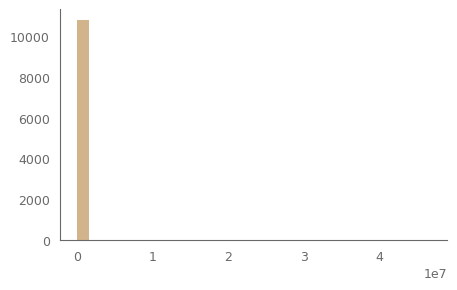

In [246]:
data['price'].hist(bins=30, grid=False, color=COLOR_PLOT)
plt.show()

In [247]:
data['price'].describe()

count    1.080000e+04
mean     4.513935e+04
std      4.735896e+05
min      2.000000e+03
25%      1.550000e+04
50%      2.500000e+04
75%      4.460000e+04
max      4.659550e+07
Name: price, dtype: float64

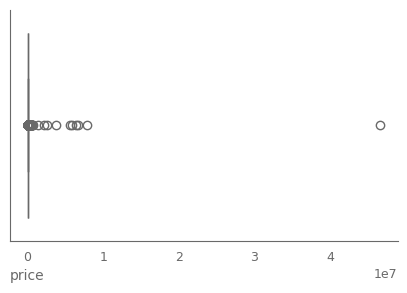

In [248]:
sns.boxplot(data['price'], orient='h', color=COLOR_PLOT)
plt.show()

It's very skewed data. Let's drop outliers.

In [249]:
data['price'].value_counts().sort_index()

price
2000        1
2500        2
3000        2
3500        1
3999        1
           ..
5822300     1
6405600     1
6689400     1
7901000     1
46595500    1
Name: count, Length: 685, dtype: int64

In [250]:
data['price'].value_counts().sort_index()[:10]

price
2000     1
2500     2
3000     2
3500     1
3999     1
4000     5
4500     3
5000    13
5400     1
5500    10
Name: count, dtype: int64

In [251]:
np.percentile(data['price'], q=0.05)

3699.3505

In [252]:
np.percentile(data['price'], q=0.1)

4000.0

In [253]:
np.percentile(data['price'], q=0.5)

6000.0

In [254]:
data['price'].value_counts().sort_index()[-25:]

price
393400      1
396700      1
405200      2
405400      2
425700      1
428900      1
445700      1
446000      1
486500      1
526700      1
527000      1
584800      1
607800      2
608100      1
769800      1
1335900     1
2201400     1
2627100     1
3790700     1
5643400     1
5822300     1
6405600     1
6689400     1
7901000     1
46595500    1
Name: count, dtype: int64

In [255]:
np.percentile(data['price'], q=99)

198721.00000000047

In [256]:
np.percentile(data['price'], q=99.5)

263400.49999999994

In [257]:
np.percentile(data['price'], q=99.8)

413560.6000000009

In [258]:
np.percentile(data['price'], q=99.85)

518720.29999998305

In [259]:
np.percentile(data['price'], q=99.9)

640601.7000001506

In [260]:
np.percentile(data['price'], q=99.95)

4903246.350000863

In [261]:
(data[(data['price'] > np.percentile(data['price'], q=0.05))
     & (data['price'] < np.percentile(data['price'], q=99.74))]
     ['price']
     .value_counts()
     .sort_index())

price
3999       1
4000       5
4500       3
5000      13
5400       1
          ..
313400     1
317400     2
320100     1
323900     1
324300     2
Name: count, Length: 655, dtype: int64

In [262]:
data = (data[(data['price'] > np.percentile(data['price'], q=0.05))
             & (data['price'] < np.percentile(data['price'], q=99.74))])

In [263]:
data.shape

(10765, 18)

In [264]:
data.to_csv('../data/real_estate_clean_drop_outliers.csv', index=False)

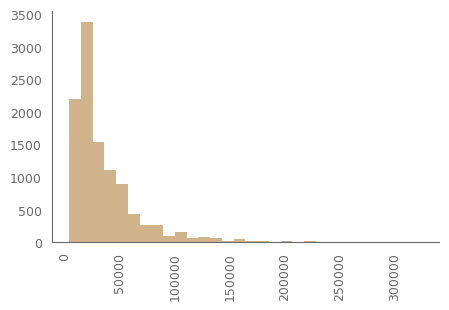

In [265]:
data['price'].hist(bins=30, grid=False, color=COLOR_PLOT)
plt.xticks(rotation=90)
plt.show()

Let's use logarithm.

In [266]:
data['price_log'] = np.log(data['price'])

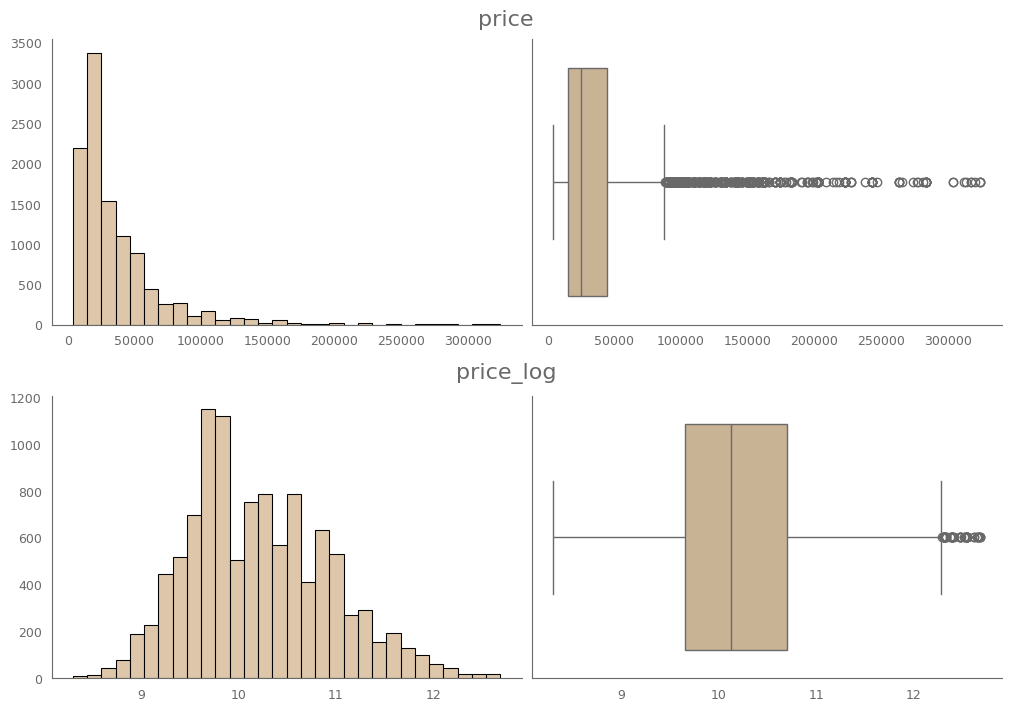

In [267]:
fig = plt.figure(layout='constrained', figsize=(10, 7))

subfigs = fig.subfigures(nrows=2, ncols=1)
targets = ['price', 'price_log']
for subfig, target in zip(subfigs, targets):
    subfig.suptitle(target, fontsize=16)
    axs = subfig.subplots(nrows=1, ncols=2)
    sns.histplot(data[target], ax=axs[0], bins=30, color=COLOR_PLOT)
    sns.boxplot(data[target], ax=axs[1], orient='h', color=COLOR_PLOT)
    for ax in axs:
        ax.set(xlabel='', ylabel='')

plt.show()


### Baseline

metric: RMSLE 

cross_validation: KFold

In [268]:
def get_train_test(df, feats, log=False):
    X = df[feats]
    if log:
        y = np.log1p(df['price'])
    else:
        y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=24)
    return X_train, X_test, y_train, y_test


def get_X_y(df, features):
    X = df[features]
    y = df['price']
    return X, y


def rmsle_score(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)


def calc_train_error(X_train, y_train, model, metric, target_log):
    '''returns in-sample error for already fit model.'''
    y_pred = model.predict(X_train)
    if target_log:
        y_pred = np.exp(y_pred)
        y_train = np.exp(y_train)
    y_pred[y_pred < 0] = 0
    return metric(y_train, y_pred)


def calc_validation_error(X_test, y_test, model, metric, target_log):
    '''returns out-of-sample error for already fit model.'''
    y_pred = model.predict(X_test)
    if target_log:
        y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    return metric(y_test, y_pred)


def calc_metrics(X_train, y_train, X_test, y_test, model, metric, target_log):
    '''fits model and returns the RMSLE for in-sample error and out-of-sample error'''
    if target_log:
        y_train = np.log(y_train)
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model, metric, target_log)
    validation_error = calc_validation_error(X_test, y_test, model, metric, target_log)
    return train_error, validation_error


def run_cv(model, X, y, folds=3, target_log=False, cv_type=KFold, success_metric=rmsle_score):
    cv = cv_type(n_splits=folds, shuffle=True, random_state=24)

    train_scores = []
    test_scores = []
    k = 0
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_score, test_score = calc_metrics(X_train, y_train, X_test, y_test,
                                               model, success_metric, target_log)
        print(f"[Fold {k}] train_rmsle: {train_score:.4f}, test_rmsle: {test_score:.4f}")
        train_scores.append(train_score)
        test_scores.append(test_score)
        k += 1

    print(f"RMSLE: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")
    return

In [269]:
data.columns

Index(['id', 'price', 'address', 'coordinates', 'region', 'subway', 'floor',
       'features', 'residential', 'neighborhood', 'description', 'detail',
       'attributes', 'num_rooms', 'full_area', 'living_area', 'kitchen_area',
       'num_storeys', 'price_log'],
      dtype='object')

In [270]:
black_list = ['id', 'price', 'price_log']

num_feats = [col for col in data.select_dtypes(exclude='object').columns
             if col not in black_list]

In [271]:
num_feats

['floor',
 'num_rooms',
 'full_area',
 'living_area',
 'kitchen_area',
 'num_storeys']

In [272]:
X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=False)

In [273]:
model = DummyRegressor(strategy='mean')

run_cv(model, X_train, y_train,
       folds=3, target_log=False,
       cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.7885, test_rmsle: 0.7789
[Fold 1] train_rmsle: 0.7833, test_rmsle: 0.8004
[Fold 2] train_rmsle: 0.7802, test_rmsle: 0.7740
RMSLE: 0.7844 ± 0.0114


In [274]:
model = DummyRegressor(strategy='median')

run_cv(model, X_train, y_train,
       folds=3, target_log=False,
       cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.7348, test_rmsle: 0.7240
[Fold 1] train_rmsle: 0.7322, test_rmsle: 0.7293
[Fold 2] train_rmsle: 0.7270, test_rmsle: 0.7408
RMSLE: 0.7314 ± 0.0070


In [275]:
model = ExtraTreesRegressor(max_depth=6, random_state=24)

run_cv(model, X_train, y_train,
       folds=3, target_log=False,
       cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.4823, test_rmsle: 0.4809
[Fold 1] train_rmsle: 0.4745, test_rmsle: 0.4883
[Fold 2] train_rmsle: 0.4733, test_rmsle: 0.4894
RMSLE: 0.4862 ± 0.0038


In [276]:
model = RandomForestRegressor(max_depth=6, random_state=24)

run_cv(model, X_train, y_train,
       folds=3, target_log=False,
       cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.4389, test_rmsle: 0.4478
[Fold 1] train_rmsle: 0.4340, test_rmsle: 0.4574
[Fold 2] train_rmsle: 0.4294, test_rmsle: 0.4599
RMSLE: 0.4550 ± 0.0052


In [277]:
model = RandomForestRegressor(max_depth=6, random_state=24)

run_cv(model, X_train, y_train,
       folds=3, target_log=True,
       cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.4199, test_rmsle: 0.4297
[Fold 1] train_rmsle: 0.4146, test_rmsle: 0.4399
[Fold 2] train_rmsle: 0.4115, test_rmsle: 0.4466
RMSLE: 0.4387 ± 0.0070


In [278]:
parameters_xgb = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmsle',
    'eta': 0.1,
    'verbosity': 1,
    'seed': 24,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',

    'max_depth': 6,
    'subsample': 0.7,
}
model = xgb.XGBRegressor(**parameters_xgb)

run_cv(model, X_train, y_train,
       folds=3, target_log=False, cv_type=KFold,
       success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3666, test_rmsle: 0.4265
[Fold 1] train_rmsle: 0.3624, test_rmsle: 0.4409
[Fold 2] train_rmsle: 0.3591, test_rmsle: 0.4427
RMSLE: 0.4367 ± 0.0073


In [279]:
run_cv(model, X_train, y_train,
       folds=3, target_log=True, cv_type=KFold,
       success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3282, test_rmsle: 0.4099
[Fold 1] train_rmsle: 0.3226, test_rmsle: 0.4214
[Fold 2] train_rmsle: 0.3172, test_rmsle: 0.4235
RMSLE: 0.4183 ± 0.0060


In [280]:
parameters_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'random_state': 24,
    'verbose': 0,
    'force_col_wise': True,

    'max_depth': 6,
    'num_leaves': 5,
    'subsample': 0.6,
    'subsample_freq': 1
}

model = lgb.LGBMRegressor(**parameters_lgb)

run_cv(model, X_train, y_train,
       folds=3, target_log=False, cv_type=KFold,
       success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.4558, test_rmsle: 0.4525
[Fold 1] train_rmsle: 0.4481, test_rmsle: 0.4609
[Fold 2] train_rmsle: 0.4446, test_rmsle: 0.4643
RMSLE: 0.4592 ± 0.0050


In [281]:
run_cv(model, X_train, y_train,
       folds=3, target_log=True, cv_type=KFold,
       success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.4235, test_rmsle: 0.4217
[Fold 1] train_rmsle: 0.4179, test_rmsle: 0.4369
[Fold 2] train_rmsle: 0.4164, test_rmsle: 0.4368
RMSLE: 0.4318 ± 0.0072
